In [18]:
# Import required packages
import math
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import norm
import time
import tejapi
plt.style.use('bmh')

# Log in TEJ API
api_key = 'YOUR_KEY'
# tejapi.ApiConfig.api_base="http://10.10.10.66"
tejapi.ApiConfig.api_key = api_key
tejapi.ApiConfig.ignoretz = True

# Import required data
gte, lte = '2021-03-16', '2023-04-20'
stocks = tejapi.get('TWN/APRCD', # stock price
                   paginate = True,
                   coid = 'Y9999',
                   mdate = {'gte':gte, 'lte':lte},
                   opts = {
                       'columns':[ 'mdate','close_d']
                   }
                  )
# Get options price
puts = tejapi.get( # puts price
    'TWN/AOPTION',
    paginate = True,
    coid = 'TXO202304P15500',
    mdate = {'gte':gte, 'lte':lte},
    opts = {
        'columns':['mdate', 'coid','settle', 'kk', 'theoremp', 'acls', 'ex_price', 'td1y', 'avolt', 'rtime']
    }
)
calls = tejapi.get( # calls price
    'TWN/AOPTION',
    paginate = True,
    coid = 'TXO202304C15500',
    mdate = {'gte':gte, 'lte':lte},
    opts = {
        'columns':['mdate', 'coid','settle', 'kk', 'theoremp', 'acls', 'ex_price', 'td1y', 'avolt', 'rtime']
    }
)

# set index
stocks = stocks.set_index('mdate')
puts = puts.set_index('mdate')
calls = calls.set_index('mdate')

# Calculate daily return  
stocks['daily return'] = np.log(stocks['close_d']) - np.log(stocks['close_d'].shift(1))
stocks['moving volatility'] = stocks['daily return'].rolling(252).std()

# Asset price simulation

In [2]:
# monte carlo simulation for underlying asset
def mc_asset(S0, r, sigma, T, Nsteps, Nrep):
    SPATH = np.zeros((Nrep, 1 + Nsteps))
    SPATH[:, 0] = S0
    dt = T / Nsteps
    nudt = (r - 0.5 * sigma **2) * dt
    sidt = sigma * np.sqrt(dt)
    
    for i in range(0,Nrep):
        for j in range(0,Nsteps):
            SPATH[i,j+1] = SPATH[i,j] * np.exp(nudt + sidt * np.random.normal())
    return SPATH

In [3]:
S0 = 100
K = 110
CallOrPut = 'call'
r = 0.03
sigma = 0.25
T = 0.5
Nsteps = 10000
Nrep = 1000
SPATH = mc_asset(S0, r, sigma, T, Nsteps, Nrep)

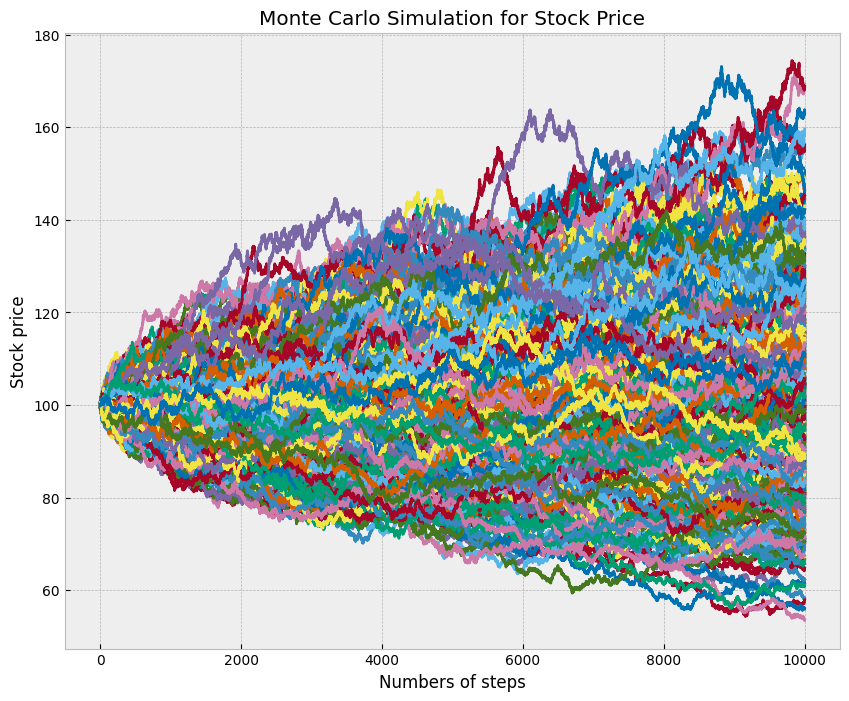

In [4]:
fig = plt.figure(figsize = (10,8))
for i in range(len(SPATH)):
    plt.plot(SPATH[i])
plt.xlabel('Numbers of steps')
plt.ylabel('Stock price')
plt.title('Monte Carlo Simulation for Stock Price')
plt.show()
# fig.savefig('monte carlo for stock price.png')

# Option price MC simulation

In [5]:
def mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep):
    SPATH = mc_asset(S0, r, sigma, T, Nsteps, Nrep)
    if CallOrPut == 'call':
        payoffs = np.maximum(SPATH[:,-1] - K, 0)
        return np.mean(payoffs)*np.exp(-r*T)
    else:
        payoffs = np.maximum(K - SPATH[:,-1], 0)
        return np.mean(payoffs)*np.exp(-r*T)

In [6]:
S0 = 100
K = 110
CallOrPut = 'put'
r = 0.03
sigma = 0.25
T = 0.5
Nsteps = 10000
Nrep = 1000
p_ = mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep)

# Black Scholes Price

In [7]:
class BS_formula:

    def __init__(self, s0, k, r, sigma, T):     
        self.s0 = s0 # 標的物價格
        self.k = k # 履約價格
        self.r = r # 無風險利率
        self.sigma = sigma # 歷史波動度
        self.T = T # 剩餘到期時間
        self.d1 = (np.log(s0/k)+(r+sigma**2/2)*T) / (sigma * np.sqrt(T))
        self.d2 = ((np.log(s0/k)+(r+sigma**2/2)*T) / (sigma * np.sqrt(T))) - sigma*np.sqrt(T)
        
    def BS_price(self): # 計算理論價格
        c = self.s0*norm.cdf(self.d1) - self.k*np.exp(-self.r*self.T)*norm.cdf(self.d2)
        p = self.k*np.exp(-self.r*self.T)*norm.cdf(-self.d2) - self.s0*norm.cdf(-self.d1)
        return c,p
        
    def BS_delta(self): # 計算 delta
        return norm.cdf(self.d1), norm.cdf(self.d1)-1
    
    def BS_gamma(self): # 計算 gamma
        return norm.pdf(self.d1)/(self.s0*self.sigma*np.sqrt(self.T)), norm.pdf(self.d1)/(self.s0*self.sigma*np.sqrt(self.T))
    
    def BS_vega(self): # 計算 vega
        return self.s0*np.sqrt(self.T)*norm.pdf(self.d1), self.s0*np.sqrt(self.T)*norm.pdf(self.d1)
    
    def BS_theta(self): # 計算 theta 
        c_theta = -self.s0*norm.pdf(self.d1)*self.sigma / (2*np.sqrt(self.T)) - self.r*self.k*np.exp(-self.r*self.T)*norm.cdf(self.d2)
        p_theta = -self.s0*norm.pdf(self.d1)*self.sigma / (2*np.sqrt(self.T)) + self.r*self.k*np.exp(-self.r*self.T)*norm.cdf(-self.d2)
        return c_theta, p_theta
    
    def BS_rho(self): # 計算 rho  
        return self.k*self.T*np.exp(-self.r*self.T)*norm.cdf(self.d2), -self.k*self.T*np.exp(-self.r*self.T)*norm.cdf(-self.d2)

In [8]:
S0 = 100
K = 110
CallOrPut = 'put'
r = 0.03
sigma = 0.25
T = 0.5

mybs = BS_formula(S0, K, r, sigma, T)
c, p = mybs.BS_price()

print(f'Monte Carlo price: {p_}')
print(f'Black Scholes price: {p}')

Monte Carlo price: 11.960636614284962
Black Scholes price: 12.260864539521961


# Antithetic Variate

In [9]:
def mc_options_AV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep):

    SPATH1 = np.zeros((int(Nrep/2), 1 + Nsteps))
    SPATH2 = np.zeros((int(Nrep/2), 1 + Nsteps))
    SPATH1[:, 0], SPATH2[:, 0] = S0, S0
    dt = T / Nsteps
    nudt = (r - 0.5 * sigma **2) * dt
    sidt = sigma * np.sqrt(dt)
    
    for i in range(0,int(Nrep/2)):
        for j in range(0,Nsteps):
            epsilon = np.random.normal()
            SPATH1[i,j+1] = SPATH1[i,j] * np.exp(nudt + sidt * epsilon)
            SPATH2[i,j+1] = SPATH2[i,j] * np.exp(nudt - sidt * epsilon)
            
    if CallOrPut == 'call':
        C1 = np.maximum(SPATH1[:, -1] - K, 0)
        C2 = np.maximum(SPATH2[:, -1] - K, 0)
        C = np.mean(0.5 * (C1 + C2))
        C0 = np.exp(-r*T) * C
        return C0
    else: 
        P1 = np.maximum(K - SPATH1[:, -1], 0)
        P2 = np.maximum(K - SPATH2[:, -1], 0)
        P = np.mean(0.5 * (P1 + P2))
        P0 = np.exp(-r*T) * P
        return P0
    

In [10]:
CallOrPut = 'put'
K = 110
S0 = 100
r = 0.03
sigma = 0.25
T = 0.5
Nrep = 10000
Nsteps = 1000

In [11]:
print('Price under AV: ', mc_options_AV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print('Price under MC: ', mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))

Price under AV:  12.290868345295795
Price under MC:  12.127912923605955


# Control Variate

In [12]:
def mc_options_CV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep, Npilot):
    
    # Calculate covariance between stock and options price
    SPATH = np.zeros((Npilot, 1 + Nsteps))
    SPATH[:, 0] = S0
    dt = T / Nsteps
    nudt = (r - 0.5 * sigma **2) * dt
    sidt = sigma * np.sqrt(dt)
    
    for i in range(0,Npilot):
        for j in range(0,Nsteps):
            SPATH[i,j+1] = SPATH[i,j] * np.exp(nudt + sidt * np.random.normal())
    Sn = SPATH[:, -1] 
    if CallOrPut == 'call':
        Cn = np.maximum(SPATH[:,-1] - K, 0) * np.exp(-r*T)
        MatCov = np.cov(Sn, Cn)[0,1]
        VarY = S0 ** 2 * np.exp(2 * r * T) * (np.exp(T * sigma ** 2) - 1)
        c = -MatCov / VarY
        ExpY = S0 * np.exp(r*T)
    else:
        Pn = np.maximum(K - SPATH[:,-1], 0) * np.exp(-r*T)
        MatCov = np.cov(Sn, Pn)[0,1]
        VarY = S0 ** 2 * np.exp(2 * r * T) * (np.exp(T * sigma ** 2) - 1)
        c = -MatCov / VarY
        ExpY = S0 * np.exp(r*T)

    
    # Applying control variate function with optimal c*
    SPATH2 = np.zeros((Nrep, 1 + Nsteps))
    SPATH2[:, 0] =S0
    dt = T / Nsteps
    nudt = (r - 0.5 * sigma **2) * dt
    sidt = sigma * np.sqrt(dt)
    
    for i in range(0,Nrep):
        for j in range(0,Nsteps):
            SPATH2[i,j+1] = SPATH2[i,j] * np.exp(nudt + sidt * np.random.normal())
    S = SPATH2[:, -1] 
    if CallOrPut == 'call':
        C = np.maximum(SPATH2[:,-1] - K, 0) * np.exp(-r*T)
        CVC = np.mean(C + c * (S - ExpY))
        return CVC
    else:
        P = np.maximum(K - SPATH2[:,-1], 0) * np.exp(-r*T)
        CVP = np.mean(P + c * (S - ExpY))
        return CVP

In [13]:
CallOrPut = 'put'
K = 110
S0 = 100
r = 0.03
sigma = 0.25
T = 0.5
Nrep = 5000
Nsteps = 1000
Npilot= 5000

print('Price under AV: ', mc_options_AV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print('Price under CV: ', mc_options_CV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep, Npilot))

Price under AV:  12.236361626848689
Price under CV:  12.252839083918078


# Real analysis

In [49]:
S0 = stocks.loc['2023-01-31']['close_d']
K = 15500 
r = stocks['daily return'].rolling(252).mean().loc['2023-01-31'] # average return of stock
T = 51 / 252
sigma = stocks.loc['2023-01-31']['moving volatility'] * np.sqrt(252)
Nstep = 10000 
Nrep = 1000
Npilot = 500
CallOrPut = 'put'

print('Monte Carlo theoretical price: ', mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print('Monte Carlo with AV theoretical price: ', mc_options_AV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print('Monte Carlo with CV theoretical price: ', mc_options_CV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep, Npilot))
print('TEJ Black Scholes price: ', puts.loc['2023-01-31']['theoremp'])
print('Real price: ', puts.loc['2023-01-31']['settle'])

Monte Carlo theoretical price:  660.4272679070154
Monte Carlo with AV theoretical price:  677.1076382207661
Monte Carlo with CV theoretical price:  696.4625241145358
TEJ Black Scholes price:  708.36501753
Real price:  650.0


In [50]:
S0 = stocks.loc['2023-01-31']['close_d']
K = 15500 
r = stocks['daily return'].rolling(252).mean().loc['2023-01-31'] # average return of stock
T = 51 / 252
sigma = stocks.loc['2023-01-31']['moving volatility'] * np.sqrt(252)
Nstep = 10000 
Nrep = 1000
Npilot = 500
CallOrPut = 'put'

print('Monte Carlo theoretical price: ', mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print('Monte Carlo with AV theoretical price: ', mc_options_AV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print('Monte Carlo with CV theoretical price: ', mc_options_CV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep, Npilot))
print('TEJ Black Scholes price: ', puts.loc['2023-01-31']['theoremp'])
print('Real price: ', puts.loc['2023-01-31']['settle'])

Monte Carlo theoretical price:  665.4633397865797
Monte Carlo with AV theoretical price:  663.0340917427103
Monte Carlo with CV theoretical price:  698.9927866523952
TEJ Black Scholes price:  708.36501753
Real price:  650.0


In [56]:
S0 = stocks.loc['2023-01-31']['close_d']
K = 15500 
r = stocks['daily return'].rolling(252).mean().loc['2023-01-31'] # average return of stock
T = 51 / 252
sigma = stocks.loc['2023-01-31']['moving volatility'] * np.sqrt(252)
Nstep = 50000 
Nrep = 50000
Npilot = 5000
CallOrPut = 'put'

print('Monte Carlo theoretical price: ', mc_options(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print('Monte Carlo with AV theoretical price: ', mc_options_AV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep))
print('Monte Carlo with CV theoretical price: ', mc_options_CV(CallOrPut, K, S0, r, sigma, T, Nsteps, Nrep, Npilot))
print('TEJ Black Scholes price: ', puts.loc['2023-01-31']['theoremp'])
print('Real price: ', puts.loc['2023-01-31']['settle'])

Monte Carlo theoretical price:  684.5885605635402
Monte Carlo with AV theoretical price:  683.6862962137704
Monte Carlo with CV theoretical price:  687.694314669818
TEJ Black Scholes price:  708.36501753
Real price:  650.0
